In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from warnings import filterwarnings
filterwarnings('ignore')

import tensorflow as tf

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random 
from termcolor import colored
from PIL import Image
import keras

In [2]:
sns.set_style('darkgrid')

In [3]:
# Location of main dataset
base_dir  = 'Animal-Detection'
# Show main directory containers
os.listdir(base_dir)

['test', 'train']

In [4]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [5]:
classes = os.listdir(train_dir)
num_classes = len(classes)

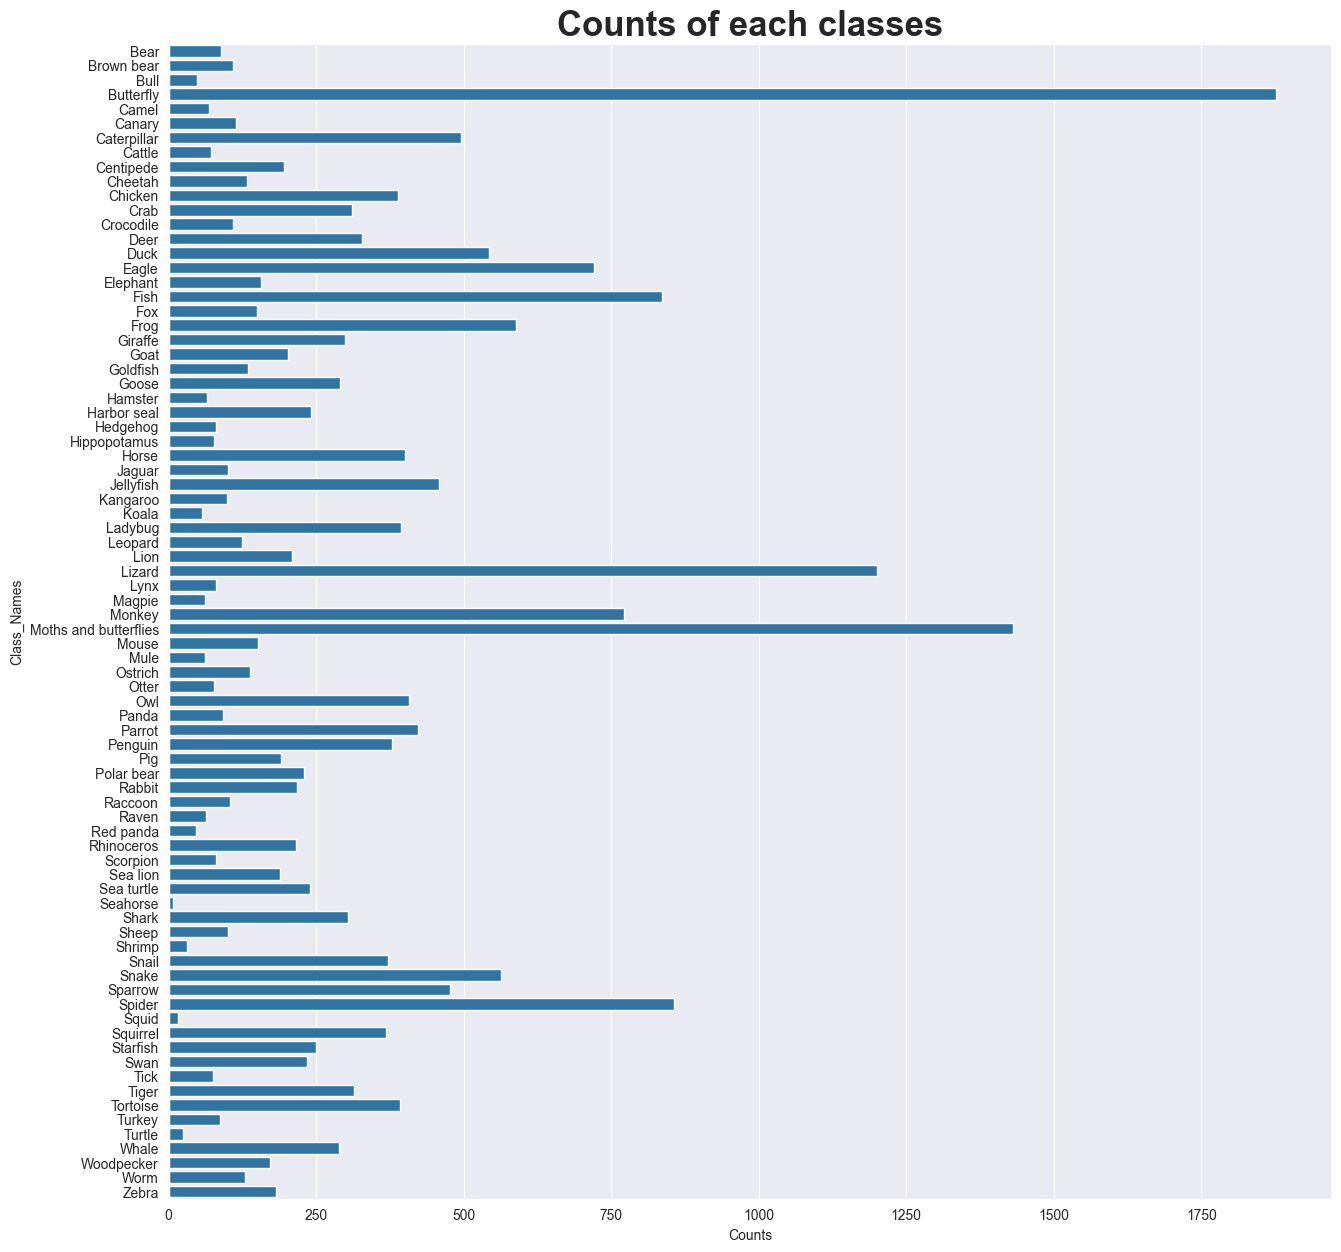

In [6]:
counts = []

for class_name in classes :
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    counts.append((class_name, count))

counts = pd.DataFrame(counts,columns=['Class_Names', 'Counts'])

plt.figure(figsize=(15, 15))
ax = sns.barplot(data=counts, y='Class_Names', x='Counts')
ax.set_title('Counts of each classes', fontsize=25, fontweight='bold')

plt.show()

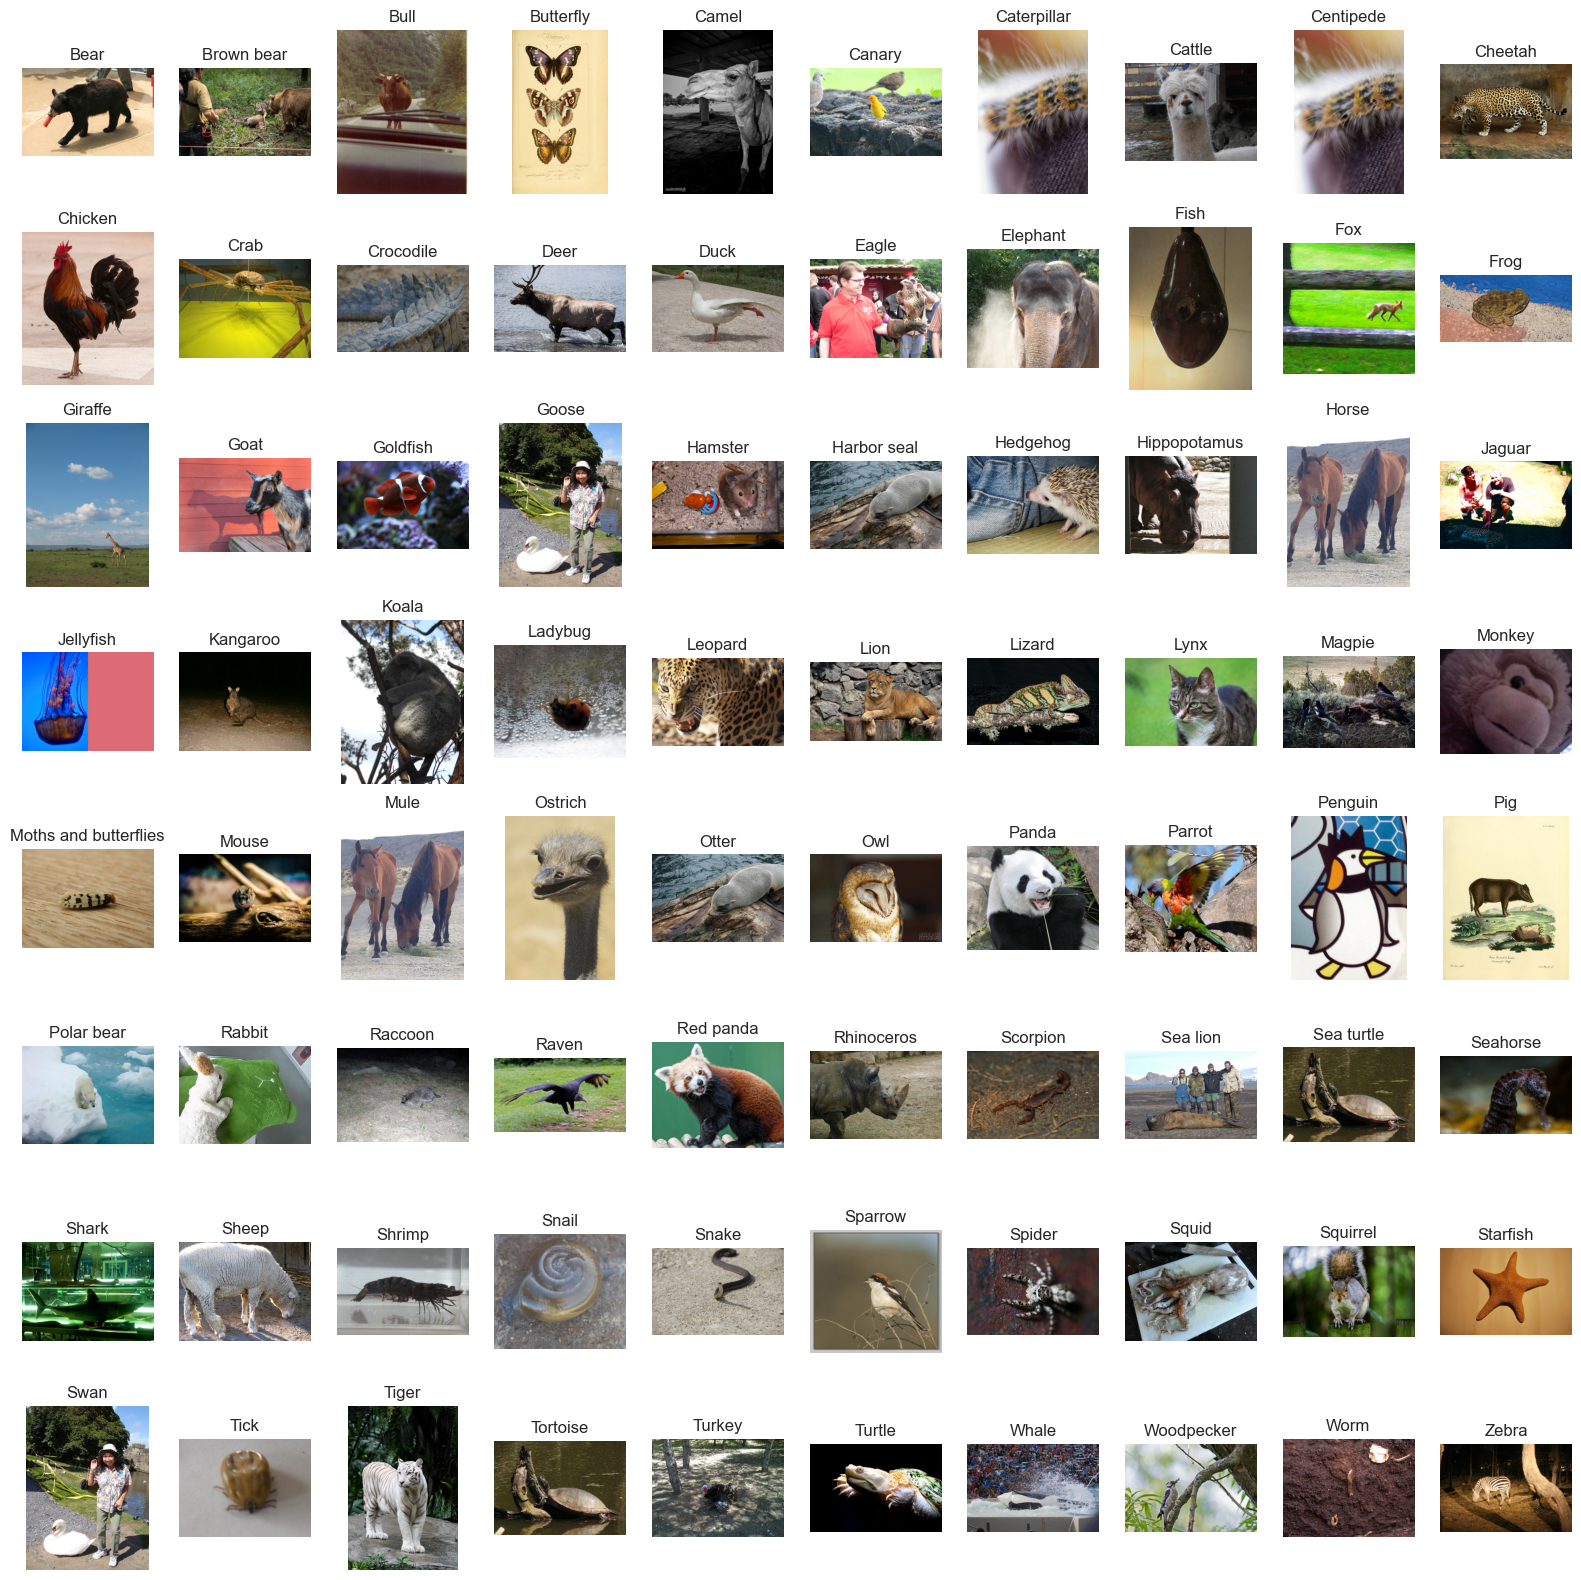

In [7]:
fig, ax = plt.subplots(8, 10, figsize=(20, 20))

# Loop over classes
for i in range(len(classes)) :    
    class_name = classes[i]
    class_path = os.path.join(train_dir, class_name)
    img = [file for file in os.listdir(class_path) if file.endswith('.jpg')]
    img = os.path.join(class_path, img[0])
    img = Image.open(img)
    
    # Define index of each image in 8*10 plot
    col = i // 10
    row = i % 10

    ax[col, row].imshow(img)
    ax[col, row].axis('off')
    ax[col, row].set_title(class_name)
plt.show()

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

train_full = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

Found 22566 files belonging to 80 classes.


In [9]:
train_full = train_full.shuffle(1024).prefetch(tf.data.AUTOTUNE)

In [10]:
num_all_batches = len(list(train_full))
print(colored(f'Number of all Batches : {num_all_batches}', 'white', 'on_blue', attrs=['bold']))

Number of all Batches : 706


In [11]:
num_train_batches = int(num_all_batches * 0.8)
num_valid_test_batches = int(num_all_batches - num_train_batches)

print(colored(' Target : ', 'green', attrs=['bold']))
print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

 Target : 
Number of  Train  batches : 564
Number of Validation batches : 71
Number of Test batches : 71


In [12]:
train_ds = train_full.take(num_train_batches)
remain = train_full.skip(num_train_batches)
valid_ds = remain.take(num_valid_test_batches//2)
test_ds = remain.skip(num_valid_test_batches//2)

# Print number of batches in train, validation and test dataset after split them
print(colored(f'Number of train batches : {len(list(train_ds))}', 'green', attrs=['bold']))
print(colored(f'Number of valid batches : {len(list(valid_ds))}', 'green', attrs=['bold']))
print(colored(f'Number of test  batches : {len(list(test_ds))}', 'green', attrs=['bold']))

Number of train batches : 564
Number of valid batches : 71
Number of test  batches : 71


In [13]:
# Load VGG19 pretrained model with imagenet weights
pretrained_model = keras.applications.VGG19(
    weights='imagenet', classes=80, input_shape=(224, 224, 3), include_top=False
)
# Show information of ResNet50V2 layers
pretrained_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
pretrained_model.trainable = True
set_trainable = False

for layer in pretrained_model.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
model = keras.models.Sequential()
model.add(pretrained_model)
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.GlobalAveragePooling2D())  
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation='relu')) 
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(80, activation='softmax'))

In [16]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True)
# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# BackupAndRestore callback for resumable training
backup_dir = os.path.join(os.getcwd(), 'backup')
if not os.path.exists(backup_dir):
    os.makedirs(backup_dir)
backup_cb = keras.callbacks.BackupAndRestore(backup_dir=backup_dir)


In [17]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Train model by .fit function
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=50,                                       # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr, backup_cb] # List of call backs
)

Epoch 6/50


564/564 ━━━━━━━━━━━━━━━━━━━━ 1996s 3s/step - accuracy: 0.6134 - loss: 1.4573 - val_accuracy: 0.7210 - val_loss: 1.0003 - learning_rate: 1.0000e-04
Epoch 7/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 3098s 5s/step - accuracy: 0.6672 - loss: 1.2169 - val_accuracy: 0.7548 - val_loss: 0.8686 - learning_rate: 1.0000e-04
Epoch 8/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 1849s 3s/step - accuracy: 0.7124 - loss: 1.0223 - val_accuracy: 0.7989 - val_loss: 0.6862 - learning_rate: 1.0000e-04
Epoch 9/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 6107s 11s/step - accuracy: 0.7407 - loss: 0.8983 - val_accuracy: 0.8253 - val_loss: 0.6064 - learning_rate: 1.0000e-04
Epoch 10/50
 75/564 ━━━━━━━━━━━━━━━━━━━━ 20:37 3s/step - accuracy: 0.7908 - loss: 0.7024

KeyboardInterrupt: 